In [2]:
import numpy as np
from scipy import stats as st

from jax import numpy as jnp
from jax import jit, vmap, random
import jax; jax.config.update('jax_platform_name', 'cpu')

from matplotlib import pyplot as plt

In [15]:
%config InlineBackend.figure_format = 'svg'
plt.style.use(['thesis','ghd-notebook-svg'])

### Outline

- Inference problem.
    - Independent inference single cell figure.
    - Independent inference join plot with marginals
    - Joint inference figure with marginals
- Lateral Inhibition.
    - Phase portrait.
    - Simulations.
- Results.
    - Joint + marginal distribution t=0 → t=T plot.
    - Correlated Joint + marginal distribution t=0 → t=T plot.
    - Noisy Joint + marginal distribution t=0 → t=T plot.
    - Marginal mutual information plot [?]
    


## Inference Problem

### Figure: Independent inference

In [46]:
from plotting_tools import plot_gauss_curves
from scipy import stats as st

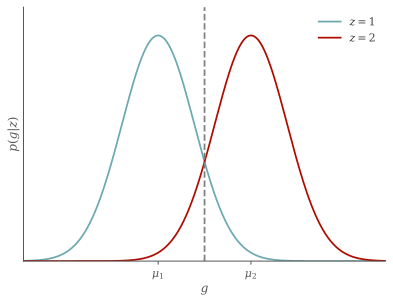

In [47]:
xlims = (-5,5)
g = np.linspace(*xlims,1000)
τ = st.norm.ppf(0.90)
#μ1, μ2 = -1.4, 1.4
μ1, μ2 = -τ, τ
μ = [μ1, μ2]
thresh = (μ1 + μ2) / 2

fig, ax = plt.subplots(1,1)

ax = plot_gauss_curves(μ,xlims,ax=ax,colors=["C2","C5"]);

ax.vlines(thresh,0,0.5,ls='--',color="grey");

ax.set_xticks([μ1,μ2])
ax.set_xticklabels([r"$\mu_1$","$\mu_2$"])
ax.set_yticks([])

ax.set_xlim(*xlims);

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("$g$")
ax.set_ylabel("$p(g|z)$")

plt.legend();

In [141]:
τ = st.norm.ppf(0.90)
#μ1, μ2 = -1.4, 1.4
μ1, μ2 = -τ, τ
F1 = st.norm.cdf(0,loc=-τ)
F2 = st.norm.cdf(0,loc=τ)
print(f"{F1=:.3f}",f"{F2=:.3f}")

F1=0.900 F2=0.100


In [ ]:
st.norm.cdf

### Figure: Joint inference with marginals

In [48]:
from plotting_tools import mesh_density, plot_joint_density, plot_gauss_curves, plot_joint_with_marginals

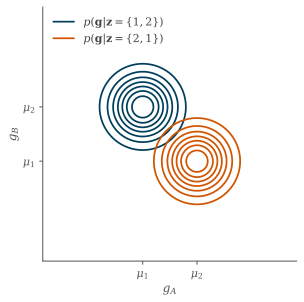

In [49]:
lims = (-6,6)

τ = st.norm.ppf(0.90)
μ1, μ2 = -τ, τ
#μ1, μ2 = -1.4, 1.4
z1, z2 = [0,1], [1,0]
μ = np.array([μ1,μ2])
mean1, mean2 = μ[z1], μ[z2]
cov = np.diag([1,1])

plot_joint_density(μ,cov,lims);

#### No boundaries

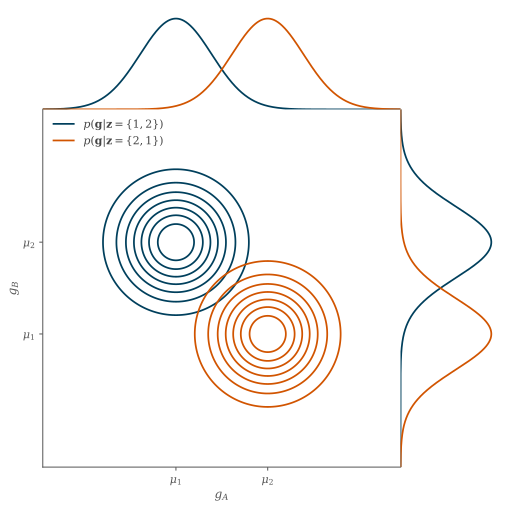

In [50]:
lims = (-5,5)

τ = st.norm.ppf(0.90)
μ1, μ2 = -τ, τ
z1, z2 = [0,1], [1,0]
μ = np.array([μ1,μ2])
cov = np.diag([1,1])

plot_joint_with_marginals(μ,cov,lims);

#### Independent inference boundaries

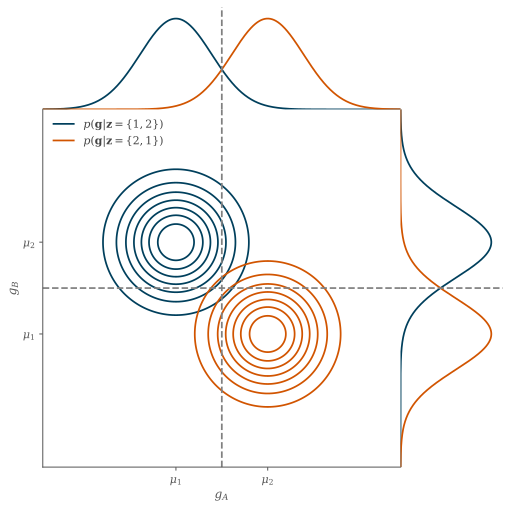

In [53]:
lims = (-5,5)


τ = st.norm.ppf(0.90)
μ1, μ2 = -τ, τ
z1, z2 = [0,1], [1,0]
μ = np.array([μ1,μ2])
cov = np.diag([1,1])

ax_joint, ax_marg1, ax_marg2 = plot_joint_with_marginals(μ,cov,lims);

ax_joint.vlines((μ1+μ2)/2,*lims,ls="--",color="grey")
ax_joint.hlines((μ1+μ2)/2,*lims,ls="--",color="grey")

y_min, y_max = ax_marg1.get_ylim()
ax_marg1.vlines((μ1+μ2)/2,y_min,y_max,ls="--",color="grey")
ax_marg2.hlines((μ1+μ2)/2,y_min,y_max,ls="--",color="grey");

#### Joint inference boundaries

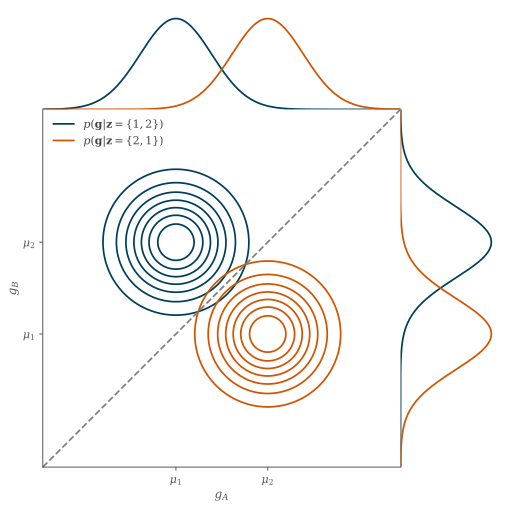

In [54]:
lims = (-5,5)

τ = st.norm.ppf(0.90)
μ1, μ2 = -τ, τ
z1, z2 = [0,1], [1,0]
μ = np.array([μ1,μ2])
cov = np.diag([1,1])

ax_joint, ax_marg1, ax_marg2 = plot_joint_with_marginals(μ,cov,lims);

ax_joint.plot(list(lims),list(lims),ls="--",color="grey");

TODO:
- Put legend in the right place
    - ~~Maybe top left for all.~~
- Decide on final legend labels
    - Maybe make them a bit more explit e.g. $z_1 = 1,\; z_2 = 2$.

## SDE Results

In [61]:
import jax
from jax import numpy as jnp
from jax import random
jax.config.update('jax_platform_name', 'cpu')

from sde_systems.jax_delta_notch import DN_sdeint_ito
from sde_systems.delta_notch_tools import plot_delta_notch_time_course, sample_y0_DN, sample_y0_DN_mixed, calculate_y0_std

In [62]:
t0, t1 = 0, 6
nsteps = 1000
ts = jnp.linspace(t0, t1, nsteps)

noise_scale = 0.05
args = (0.01,100,4,4, noise_scale)

DN_sdeint = jit(vmap(lambda y0,rng: DN_sdeint_ito(y0,ts,rng,args,dt=0.01)))

In [63]:
μ1, μ2 = 0.4,0.6
std = calculate_y0_std(μ1,μ2)
cov = np.diag([1,1]) * 0.0035 
n_samples = 100
z_batch_size = int(n_samples/2)
y0 = sample_y0_DN_mixed(μ1, μ2, cov, z_batch_size)
rng = random.PRNGKey(0)
rngs = random.split(rng, n_samples)

ys = DN_sdeint(y0,rngs)
ys_z0 = drop_nans(ys[:z_batch_size,...])
ys_z1 = drop_nans(ys[z_batch_size:,...])

### Figure: Expression Time Course 

#### All genes vs time

In [64]:
import jax
from jax import numpy as jnp
from jax import random
jax.config.update('jax_platform_name', 'cpu')

from sde_systems.jax_delta_notch import DN_sdeint_ito
from sde_systems.delta_notch_tools import plot_delta_notch_time_course

##### Stochastic

In [65]:
t0, t1 = 0, 6
nsteps = 1000
ts = jnp.linspace(t0, t1, nsteps)

noise_scale = 0.05
args = (0.01,100,4,4,noise_scale)

μ1, μ2 = 0.4,0.6
y0 = np.array([μ1,μ2,0.5,0.5])

rng = random.PRNGKey(0)

y = DN_sdeint_ito(y0,ts,rng,args,dt=0.01)

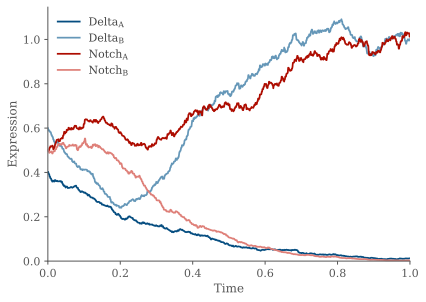

In [66]:
plot_delta_notch_time_course(y)

##### Deterministic

In [67]:
t0, t1 = 0, 6
nsteps = 1000
ts = jnp.linspace(t0, t1, nsteps)

noise_scale = 0.0
args = (0.01,100,4,4,noise_scale)

μ1, μ2 = 0.4,0.6
y0 = np.array([μ1,μ2,0.5,0.5])

rng = random.PRNGKey(0)

y = DN_sdeint_ito(y0,ts,rng,args,dt=0.01)

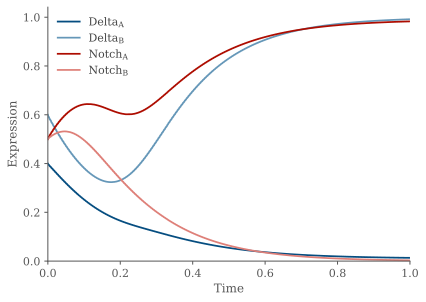

In [68]:
plot_delta_notch_time_course(y)

#### Delta1 vs Delta2

In [503]:
import jax
from jax import numpy as jnp
from jax import random
jax.config.update('jax_platform_name', 'cpu')

from matplotlib.collections import LineCollection

from sde_systems.jax_delta_notch import DN_sdeint_ito
from sde_systems.delta_notch_tools import plot_delta_delta_time_course

##### Stochastic

In [513]:
t0, t1 = 0, 6
nsteps = 1000
ts = jnp.linspace(t0, t1, nsteps)

noise_scale = 0.05
args = (0.01,100,4,4,noise_scale)

μ1, μ2 = 0.4,0.6
y0 = np.array([μ1,μ2,0.5,0.5])

rng = random.PRNGKey(0)

y = DN_sdeint_ito(y0,ts,rng,args,dt=0.01)

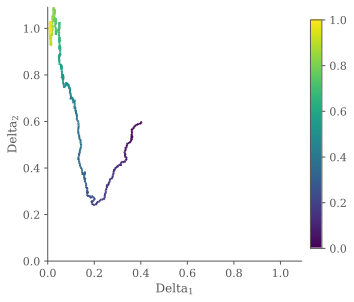

In [514]:
plot_delta_delta_time_course(y)

##### Deterministic

In [515]:
t0, t1 = 0, 6
nsteps = 1000
ts = jnp.linspace(t0, t1, nsteps)

noise_scale = 0.0
args = (0.01,100,4,4,noise_scale)

μ1, μ2 = 0.4,0.6
y0 = np.array([μ1,μ2,0.5,0.5])

rng = random.PRNGKey(0)

y = DN_sdeint_ito(y0,ts,rng,args,dt=0.01)

In [ ]:
fig, ax = plt.subplots()
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax,fraction=0.05, shrink=0.9, pad=-0.2)

(0.0, 1.0)

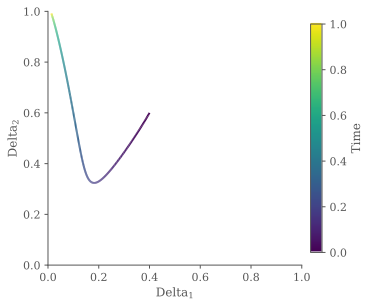

In [529]:
plot_delta_delta_time_course(y)
plt.xlim(0,1)
plt.ylim(0,1)

### Figure: delta-delta separation

#### Deterministic

In [17]:
from sde_systems.jax_delta_notch import DN_sdeint_ito
from sde_systems.delta_notch_tools import plot_DN_state_space, sample_y0_DN

In [24]:
DN_sdeint = jit(vmap(lambda y0, key, args: DN_sdeint_ito(y0,ts,key,args,dt=0.001),
                     (0,0,None)))

(0.0, 1.0)

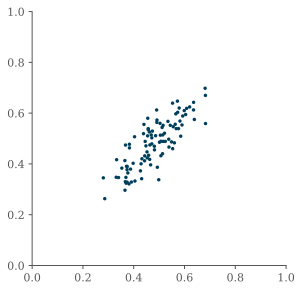

In [51]:
N_samples = 100
μ1, μ2 = 0.5,0.5
cov = np.array([[1,0.8],
                [0.8,1]]) * 0.01
y0 = sample_y0_DN(μ1,μ2,cov,N_samples)
plt.plot(y0[:,0],y0[:,1],'.')
plt.axis('scaled')
plt.xlim(0,1)
plt.ylim(0,1)

In [111]:
t0, t1 = 0, 6
nsteps = 1000
ts = jnp.linspace(t0, t1, nsteps)

noise_scale = 0.0
args = (0.01,100,4,4,noise_scale)

N_samples = 100
μ1, μ2 = 0.5,0.5
cov = np.array([[1,0.9],
                [0.9,1]]) * 0.02
np.random.seed(111)
y0 = sample_y0_DN(μ1,μ2,cov,N_samples)

key = random.PRNGKey(0)
keys = random.split(key,N_samples)

y = DN_sdeint(y0,keys,args)

dA0, dB0 = y[:,0,:2].T
dA1, dB1 = y[:,-1,:2].T
y_A = y[dA1 > dB1,...]
y_B = y[dA1 < dB1,...]

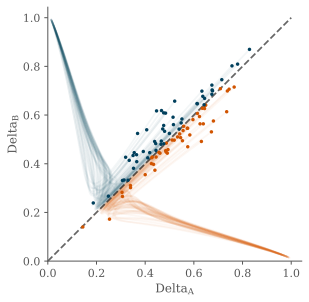

In [114]:
fig,ax = plt.subplots()
plot_DN_state_space(y_A,ax=ax,color="C1",alpha=0.05);
plot_DN_state_space(y_B,ax=ax,color="C0",alpha=0.05);
ax.plot([0,1],[0,1],color="black",ls="--",alpha=0.6);
ax.plot(*y_A[:,0,:2].T,'.',color="C1");
ax.plot(*y_B[:,0,:2].T,'.',color="C0");

ax.set_xlabel(r"$\mathrm{Delta_A}$")
ax.set_ylabel(r"$\mathrm{Delta_B}$");

#### Stochastic

In [115]:
from sde_systems.jax_delta_notch import DN_sdeint_ito
from sde_systems.delta_notch_tools import plot_delta_delta_time_course, plot_DN_state_space, sample_y0_DN

In [116]:
DN_sdeint = jit(vmap(lambda y0, key, args: DN_sdeint_ito(y0,ts,key,args,dt=0.001),
                     (0,0,None)))

In [117]:
t0, t1 = 0, 6
nsteps = 1000
ts = jnp.linspace(t0, t1, nsteps)

noise_scale = 0.05
args = (0.01,100,4,4,noise_scale)

N_samples = 100
μ1, μ2 = 0.5,0.5
cov = np.array([[1,0.9],
                [0.9,1]]) * 0.02
np.random.seed(111)
y0 = sample_y0_DN(μ1,μ2,cov,N_samples)

key = random.PRNGKey(0)
keys = random.split(key,N_samples)

y = DN_sdeint(y0,keys,args)

dA0, dB0 = y[:,0,:2].T
dA1, dB1 = y[:,-1,:2].T
y_A = y[dA1 > dB1,...]
y_B = y[dA1 < dB1,...]

In [118]:
fig,ax = plt.subplots()
plot_DN_state_space(y_A,ax=ax,color="C1",alpha=0.05);
plot_DN_state_space(y_B,ax=ax,color="C0",alpha=0.05);
ax.plot([0,1],[0,1],color="black",ls="--",alpha=0.6);
ax.plot(*y_A[:,0,:2].T,'.',color="C1");
ax.plot(*y_B[:,0,:2].T,'.',color="C0");

ax.set_xlabel(r"$\mathrm{Delta_A}$")
ax.set_ylabel(r"$\mathrm{Delta_B}$");

### Figure: Contour plot t0 vs t1.

In [199]:
from sde_systems.delta_notch_tools import drop_nans_DN, load_sde_results
from plotting_tools import make_joint_and_marginal_axes, plot_joint_and_marginal_kde

In [200]:
RESULTS_FILE = "results/noise_experiments/delta_delta_t0t1_2/DD_t0t1_noise-0000_{}.txt"
ys_load = load_sde_results(RESULTS_FILE,genes=["deltaA","deltaB"])

In [201]:
ys_load.shape

(100000, 2, 2)

In [202]:
genes = ["delta1","delta2","notch1","notch2"]
n_samples = 100000
ys = np.zeros((n_samples,100,4))
for n,g in enumerate(genes):
    RESULTS_FILE = f"results/DN_trajectories_04-06_{g}.txt"
    ys[:,:,n] = np.loadtxt(RESULTS_FILE)
    
z_batch_size = int(n_samples/2)
ys_z0 = drop_nans_DN(ys[:z_batch_size,...])
ys_z1 = drop_nans_DN(ys[z_batch_size:,...])

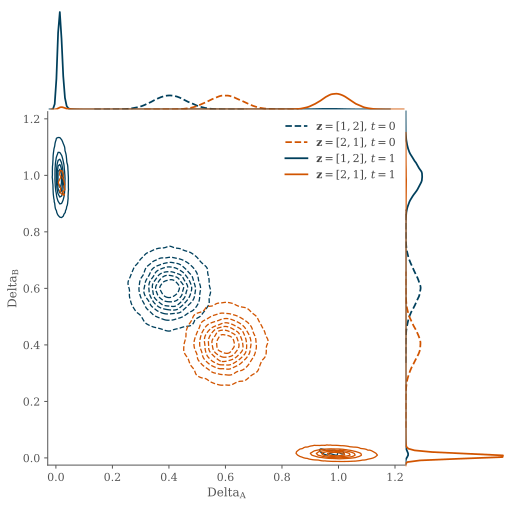

In [218]:
ax_joint, ax_marg1, ax_marg2 = make_joint_and_marginal_axes()
axs = (ax_joint, ax_marg1, ax_marg2)

sample_size = 50000
y0_z0 = ys_z0[:sample_size,0,:2]
y1_z0 = ys_z0[:sample_size,-1,:2]
y0_z1 = ys_z1[:sample_size,0,:2]
y1_z1 = ys_z1[:sample_size,-1,:2]

plot_joint_and_marginal_kde(y0_z0, axs, t=0,z=0)
plot_joint_and_marginal_kde(y0_z1, axs, t=0,z=1)
plot_joint_and_marginal_kde(y1_z0, axs, t=1,z=0)
plot_joint_and_marginal_kde(y1_z1, axs, t=1,z=1)

ax_joint.axis('scaled');
ax_joint.set_xlabel(r"$\mathrm{Delta_A}$");
ax_joint.set_ylabel(r"$\mathrm{Delta_B}$");

handles,labels = ax_marg1.get_legend_handles_labels()
ax_joint.legend(handles,labels);

In [442]:
t0, t1 = 0, 6
nsteps = 1000
ts = jnp.linspace(t0, t1, nsteps)

args = (0.01,100,4,4)

DN_sdeint = jit(vmap(lambda y0,rng: DN_sdeint_ito(y0,ts,rng,args,dt=0.01)))

In [443]:
μ1, μ2 = 0.4,0.6
cov = np.diag([1,1]) * (μ2-μ1)/2.8
n_samples = 100
z_batch_size = int(n_samples/2)
y0 = sample_y0_DN_mixed(μ1, μ2, cov, z_batch_size)

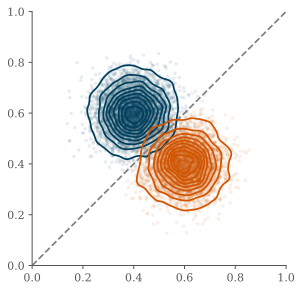

In [485]:
μ1, μ2 = 0.4,0.6
cov = np.diag([1,1]) * ((μ2-μ1)/2.8)**2
n_samples = 10000
z_batch_size = int(n_samples/2)
y0 = sample_y0_DN_mixed(μ1, μ2, cov, z_batch_size)

y0_z0 = y0[:z_batch_size,:2]
y0_z1 = y0[z_batch_size:,:2]
plt.plot(*y0_z0.T,'.',alpha=0.1)
plt.plot(*y0_z1.T,'.',alpha=0.1);
plt.plot([0,1],[0,1],color="grey",ls="--");
sns.kdeplot(x=y0_z0[:,0],y=y0_z0[:,1],color="C0");
sns.kdeplot(x=y0_z1[:,0],y=y0_z1[:,1],color="C1");
plt.axis("scaled");
plt.xlim(0,1)
plt.ylim(0,1);

In [ ]:
## μ1, μ2 = 0.4,0.6
cov = np.diag([1,1]) * 0.0035 
n_samples = 100
z_batch_size = int(n_samples/2)
y0 = sample_y0_DN_mixed(μ1, μ2, cov, z_batch_size)
rng = random.PRNGKey(0)
rngs = random.split(rng, n_samples)

ys = DN_sdeint(y0,rngs)
ys_z0 = drop_nans(ys[:z_batch_size,...])
ys_z1 = drop_nans(ys[z_batch_size:,...])

#### Take 2

In [220]:
from sde_systems.delta_notch_tools import drop_nans_DN, load_sde_results
from plotting_tools import make_joint_and_marginal_axes, plot_joint_and_marginal_kde

In [239]:
RESULTS_FILE = "results/noise_experiments/delta_delta_t0t1_2/DD_t0t1_noise-0500_{}.txt"
ys_load = load_sde_results(RESULTS_FILE,genes=["deltaA","deltaB"])

In [240]:
ys_load.shape

(91499, 2, 2)

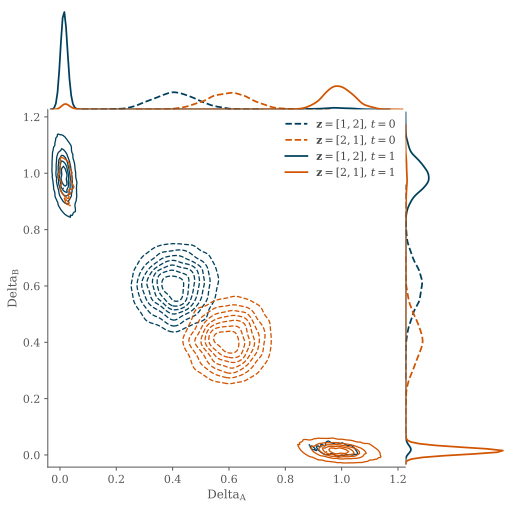

In [245]:
ax_joint, ax_marg1, ax_marg2 = make_joint_and_marginal_axes()
axs = (ax_joint, ax_marg1, ax_marg2)

n_subsamples = 5000
y0_z1, y0_z2 = ys_load[:n_subsamples,0,:].T
y1_z1, y1_z2 = ys_load[:n_subsamples,1,:].T

y0_z12 = np.vstack((y0_z1, y0_z2)).T
y0_z21 = np.vstack((y0_z2, y0_z1)).T
y1_z12 = np.vstack((y1_z1, y1_z2)).T
y1_z21 = np.vstack((y1_z2, y1_z1)).T

plot_joint_and_marginal_kde(y0_z12, axs, t=0,z=0)
plot_joint_and_marginal_kde(y0_z21, axs, t=0,z=1)
plot_joint_and_marginal_kde(y1_z12, axs, t=1,z=0)
plot_joint_and_marginal_kde(y1_z21, axs, t=1,z=1)

ax_joint.axis('scaled');
ax_joint.set_xlabel(r"$\mathrm{Delta_A}$");
ax_joint.set_ylabel(r"$\mathrm{Delta_B}$");

handles,labels = ax_marg1.get_legend_handles_labels()
ax_joint.legend(handles,labels);

### Figure: Marginal Delta t0 vs t1.

In [250]:
from sde_systems.delta_notch_tools import drop_nans_DN, load_sde_results, calculate_y0_std
from plotting_tools import make_joint_and_marginal_axes, plot_joint_and_marginal_kde

import seaborn as sns

In [251]:
RESULTS_FILE = "results/noise_experiments/delta_delta_t0t1_2/DD_t0t1_noise-0500_{}.txt"
ys_load = load_sde_results(RESULTS_FILE,genes=["deltaA","deltaB"])

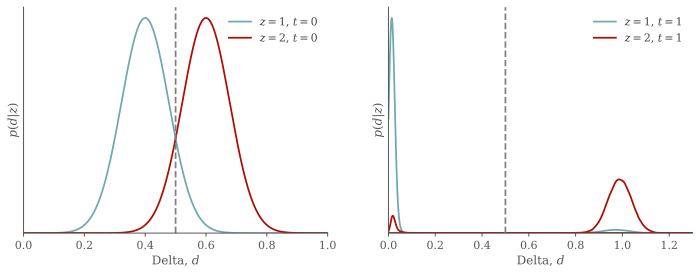

In [252]:
x = np.linspace(0,1.3,1000)

n_subsamples = len(ys_load)
#n_subsamples = 10000

y1_z1, y1_z2 = ys_load[:n_subsamples,1,:].T

y1_z1_mask = y1_z1 < 0.5
y1_z2_mask = y1_z2 < 0.5

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

μ1, μ2 = 0.4, 0.6
σ = calculate_y0_std(μ_1, μ_2)
f0_z1 = st.norm(loc=μ1, scale=σ).pdf
f0_z2 = st.norm(loc=μ2, scale=σ).pdf

ax1.plot(x,f0_z1(x), color="C2", label="$z=1$, $t=0$");
ax1.plot(x,f0_z2(x), color="C5", label="$z=2$, $t=0$");

f1_z1_0 = lambda x: st.kde.gaussian_kde(y1_z1[y1_z1_mask],bw_method=1)(x) * sum(y1_z1_mask)/len(y1_z1)
f1_z1_1 = lambda x: st.kde.gaussian_kde(y1_z1[~y1_z1_mask])(x) * sum(~y1_z1_mask)/len(y1_z1)
ax2.plot(x,f1_z1_0(x), color="C2", label="$z=1$, $t=1$");
ax2.plot(x,f1_z1_1(x), color="C2");

f1_z2_0 = lambda x: st.kde.gaussian_kde(y1_z2[y1_z2_mask])(x) * sum(y1_z2_mask)/len(y1_z2)
f1_z2_1 = lambda x: st.kde.gaussian_kde(y1_z2[~y1_z2_mask])(x) * sum(~y1_z2_mask)/len(y1_z2)
ax2.plot(x,f1_z2_0(x), color="C5", label="$z=2$, $t=1$");
ax2.plot(x,f1_z2_1(x), color="C5");

ax1.set_xlim((0,1.0));
ax2.set_xlim((0,1.3));

for ax in (ax1,ax2):
    ylims = ax.get_ylim()
    ax.vlines(0.5,0,ylims[1],ls="--",color="grey")
    ax.set_ylim((0,ylims[1]));
    ax.set_yticks([])
    ax.set_xlabel("Delta, $d$")
    ax.set_ylabel("$p(d | z)$")
    ax.legend()

In [180]:
0.5 * sum(y0_z1 < 0.5) / len(y0_z1) + 0.5 * sum(y0_z2 > 0.5) / len(y0_z2)

0.895009781527667

In [181]:
0.5 * sum(y1_z1 < 0.5) / len(y1_z1) + 0.5 * sum(y1_z2 > 0.5) / len(y1_z2)

0.934726062579919

In [264]:
dA1, dB1 = ys_load[:,-1,:2].T
p_t1 = optimal_threshold_joint_perf(dA1,dB1)
print(p_t1)

0.9346878107957464


In [270]:
p_t0 = 0.9
p_t0_joint = 0.81
print((1 - p_t1) / (1 - p_t0))
print((1 - p_t0_joint) / (1 - p_t1))

0.6531218920425365
2.9091047523427016


#### Entropy

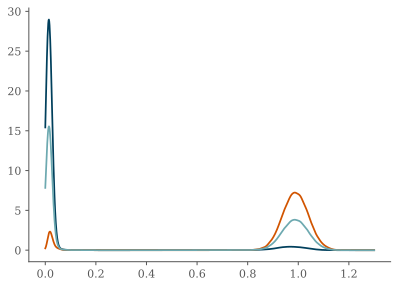

In [256]:
x = np.linspace(0,1.3,1000)

n_subsamples = len(ys_load)

y1_z1, y1_z2 = ys_load[:n_subsamples,1,:].T

y1_z1_mask = y1_z1 < 0.5
y1_z2_mask = y1_z2 < 0.5

f1_z1_0 = lambda x: st.kde.gaussian_kde(y1_z1[y1_z1_mask],bw_method=1)(x) * sum(y1_z1_mask)/len(y1_z1)
f1_z1_1 = lambda x: st.kde.gaussian_kde(y1_z1[~y1_z1_mask])(x) * sum(~y1_z1_mask)/len(y1_z1)
f1_z1 = lambda x: f1_z1_0(x) + f1_z1_1(x)

f1_z2_0 = lambda x: st.kde.gaussian_kde(y1_z2[y1_z2_mask])(x) * sum(y1_z2_mask)/len(y1_z2)
f1_z2_1 = lambda x: st.kde.gaussian_kde(y1_z2[~y1_z2_mask])(x) * sum(~y1_z2_mask)/len(y1_z2)
f1_z2 = lambda x: f1_z2_0(x) + f1_z2_1(x)

fmix = lambda x: 0.5 * f1_z1(x) + 0.5 * f1_z2(x)

plt.plot(x,f1_z1(x));
plt.plot(x,f1_z2(x));
plt.plot(x,fmix(x));

In [263]:
def P(f,x):
    p = f(x)
    return p / p.sum()

H = lambda p: st.entropy(p, base=2.0)

Hmix = H(P(fmix,x))
Hcond = H(P(f1_z1,x)) * 0.5 + H(P(f1_z2,x)) * 0.5 
print(Hmix)
print(Hcond)
print(Hmix - Hcond)

7.310047847302525
6.605399543828936
0.7046483034735891


### Figure: Performance vs Noise Scale

In [164]:
from sde_systems.delta_notch_tools import load_sde_results, optimal_threshold_joint_perf, optimal_threshold_marg_perf

In [165]:
RESULT_DIR = "results/noise_experiments/delta_delta_t0t1_2"

noise_perf = []
noise_range = np.linspace(0,0.25,101)
for noise_scale in noise_range:
    noise_str = "{:0>4d}".format(int(noise_scale*10000))
    BASE_RESULTS_STR = f"{RESULT_DIR}/DD_t0t1_noise-{noise_str}_{{}}.txt"
    ys_load = load_sde_results(BASE_RESULTS_STR, genes=["deltaA", "deltaB"])
    dA1, dB1 = ys_load[:,-1,:2].T
    noise_perf.append(optimal_threshold_joint_perf(dA1,dB1))

KeyboardInterrupt: 

In [ ]:
noise_perf

```python
OUT_FILE = "results/noise_experiments/noise_perf_000-025_101.txt"
noise_perf_array = np.array([noise_perf])
np.savetxt(OUT_FILE,noise_perf_array)
```

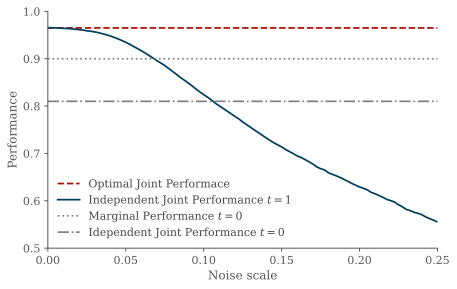

In [134]:
plt.figure(figsize=(7,4.2))

p_marg = 0.9
noise_lims = (noise_range[0],noise_range[-1])
bayes_opt = st.norm.cdf(st.norm.ppf(p_marg)*np.sqrt(2))
ind_perf = p_marg**2
plt.hlines(bayes_opt,*noise_lims,ls='--',color="C5",label="Optimal Joint Performace");
plt.plot(noise_range,noise_perf,color="C0",label="Independent Joint Performance $t=1$");
plt.hlines(p_marg,*noise_lims,ls='dotted',color="grey", label="Marginal Performance $t=0$");
plt.hlines(ind_perf,*noise_lims,ls='-.',color="grey",label="Idependent Joint Performance $t=0$");

plt.legend(loc="lower left");
plt.xlim(*noise_lims);
plt.ylim(0.5,1);
plt.xlabel("Noise scale");
plt.ylabel("Performance");

```python
RESULT_DIR = "results/noise_experiments/delta_delta_t0t1_2"

joint_noise_perf = []
marg_noise_perf = []
noise_range = np.linspace(0,0.25,101)
for noise_scale in noise_range:
    noise_str = "{:0>4d}".format(int(noise_scale*10000))
    BASE_RESULTS_STR = f"{RESULT_DIR}/DD_t0t1_noise-{noise_str}_{{}}.txt"
    ys_load = load_sde_results(BASE_RESULTS_STR, genes=["deltaA", "deltaB"])
    dA1, dB1 = ys_load[:,-1,:2].T
    joint_noise_perf.append(optimal_threshold_joint_perf(dA1,dB1))
    marg_noise_perf.append(optimal_threshold_marg_perf(dA1,dB1))
```

```python
p_marg = 0.9
noise_lims = (noise_range[0],noise_range[-1])

bayes_opt = st.norm.cdf(st.norm.ppf(p_marg)*np.sqrt(2))
ind_perf = p_marg**2

plt.hlines(bayes_opt,*noise_lims,ls='--',color="C5",label="Optimal Joint Performace");
plt.plot(noise_range,joint_noise_perf,color="C0",label="Independent Joint Performance $t=1$");
plt.plot(noise_range,marg_noise_perf,color="C2",label="Marginal Performance $t=1$");
plt.hlines(p_marg,*noise_lims,ls='--',color="grey", label="Marginal Performance $t=0$");
plt.hlines(ind_perf,*noise_lims,ls='-.',color="grey",label="Idependent Joint Performance $t=0$");

plt.legend(loc="lower left");
plt.xlim(*noise_lims);
plt.ylim(0.5,1);
plt.xlabel("Noise scale");
plt.ylabel("Performance");
```

Marginal and joint performance identical until noise ~= 0.2.